In [ ]:
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

### The binary symmetric channel
Spin values: $\pm 1$

Transition probabilities: $M=\begin{pmatrix}1-\epsilon & \epsilon\\
\epsilon&1-\epsilon\end{pmatrix}$


### One step of the hierarchical flow

In [ ]:
def makeRandFlips(spinA,  # input spins at a certain hierarchy level, as an array 
                  b,      # branching number
                  eps     # spin flip probability
                  ):
    shape1 = [b] + list(spinA.shape)
    spinA1 = np.empty(shape1, 'int')
    for a in range(b):
        flipA = np.random.rand(*list(spinA.shape)) < eps
        spinA1[a] = flipA*(-spinA)+(1-flipA)*spinA
        
    return spinA1    # spins at the next level

### The full flow

In [ ]:
def runRandFlow(depth, 
                b,
                eps,
                root=1
               ): # run a full random hierarchical flow of spin flips
    spinA = np.array([root], 'int')
    spinAL = [spinA]

    for level in range(depth):
        spinAL.append(makeRandFlips(spinAL[-1], b, eps))
    return spinAL # the full flow as a list of arrays

### Visualization of the flow as a tree

In [ ]:
def spinAL2tree(spinAL,
                plot=True,
                savefig=False
               ): # convert spin array list into a tree
    tree = nx.DiGraph()
    for level in range(len(spinAL)):
        for index, value in np.ndenumerate(spinAL[level]):
            node = tree.add_node(index)
            tree.nodes[index]['v'] = value
            if level > 0:
                predecessor = tuple(list(index)[1:])
                tree.add_edge(predecessor, index)
    
    # assign reasonable positions and colors for visualization
    pos = nx.spring_layout(tree)
    for level in range(len(spinAL)):  
        for index, value in np.ndenumerate(spinAL[level]):
            pos[index] = (np.sum([3.1**(l-level)*(index[l]-(spinAL[level].shape[l]-1.)/2)/(spinAL[level].shape[l]-1.+1e-8) 
                                  for l in range(level+1)]),
                         -level)  
    if plot:
        nx.draw(tree, pos, node_color=['b' if tree.nodes[node]['v']>0 else 'r' for node in tree.nodes], node_size=100)
        if savefig:
            plt.savefig('tree.pdf')
    return tree

### A test

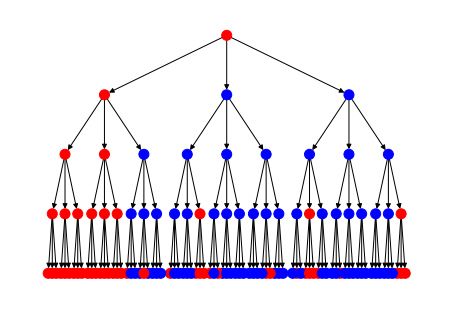

In [ ]:
spinAL = runRandFlow(depth=4, 
                     b=3,
                     eps=0.2,
                     root=-1)

tree = spinAL2tree(spinAL)

### Several algorithms reconstructing the root from the last hierarchy level 

In [ ]:
def reconstruct(spinA, # final layer 
                method,
                eps=0.5 # needed for Max Likelihood reconstruction
               ):
    if method == 'random':
        root = 2*np.random.randint(2)-1
        
    elif method == 'globalMajority':
        root = 1 if np.sum(spinA) > 0 else -1
    
    elif method == 'localMajority':
        for layer in range(len(spinA.shape)-1):
            spinA = 2*(spinA.sum(axis=0) > 0)-1
        root = int(spinA)
        
    elif method == 'maxLikelihood':
        spinApos = spinA > 0
        spinAneg = spinA < 0      
        for layer in range(len(spinA.shape)-1):
            spinApos, spinAneg = ( (spinApos*(1-eps)+spinAneg*eps).prod(axis=0), 
                                   (spinAneg*(1-eps)+spinApos*eps).prod(axis=0) )
            
            # normalize to avoid convergence to 0
            m = spinApos+spinAneg
            spinApos, spinAneg = spinApos/m, spinAneg/m
            
        root = int(2*(spinApos > spinAneg)-1)
        
    return root

### A test

True root: -1
random -1
globalMajority -1
localMajority -1
maxLikelihood -1


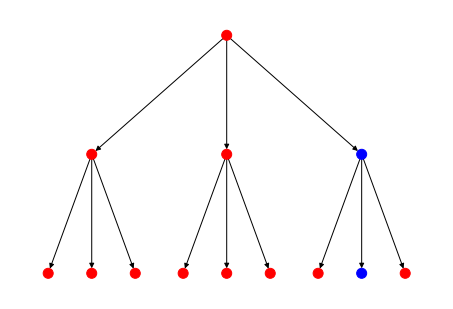

In [ ]:
def testReconstruct():
    root = 2*np.random.randint(2)-1
    print ('True root:', root)
    
    depth = 2
    b = 3
    eps = 0.2

    spinAL = runRandFlow(depth=depth, 
                 b=b,
                 eps=eps,
                 root=root)

    tree = spinAL2tree(spinAL)

    methodL = ['random', 'globalMajority', 'localMajority', 'maxLikelihood']
    for method in methodL:
        root = reconstruct(spinAL[-1], method, eps)
        print (method, root)
        
testReconstruct()

### Run multiple flows to compute the share of correct reconstructions

In [ ]:
def getShareCorrect(Nruns,
                   depth,
                   b,
                   eps,
                   methodL
                  ):
    Ncorrect = {}
    for method in methodL:
        Ncorrect[method] = 0 

    for _ in range(Nruns):
        root = 2*np.random.randint(2)-1
        spinAL = runRandFlow(depth=depth, 
                             b=b,
                             eps=eps,
                             root=root)
        for method in methodL:
            rootPred = reconstruct(spinAL[-1], method, eps)
            Ncorrect[method] += rootPred == root
    
    shareCorrect = dict([(method, float(Ncorrect[method])/Nruns) for method in methodL])
    return shareCorrect    

In [ ]:
Nruns = 1000
depth = 15
b = 2
eps = 0.2
methodL = ['random', 'globalMajority', 'localMajority', 'maxLikelihood']

results = getShareCorrect(Nruns, depth, b, eps, methodL)
for key in results:
    print (key+':', results[key])

{'globalMajority': 0.504, 'maxLikelihood': 0.499, 'localMajority': 0.501, 'random': 0.512}


### Run tests for a range of $\epsilon$

Stigum-Kesten critical epsilon: 0.1464466094067262
Aligned-spins critical epsilon: 0.25


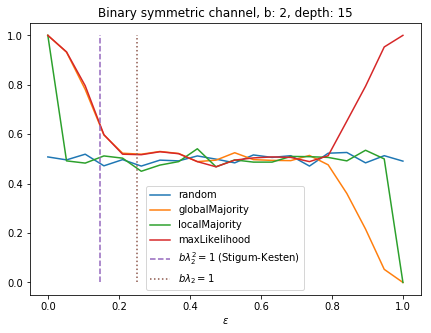

In [ ]:
Nruns = 1000
depth = 15
b = 2
epsL = np.linspace(0, 1, 20)
shareCorrect = {}
for method in methodL:
    shareCorrect[method] = []
for eps in epsL:
    res = getShareCorrect(Nruns, depth, b, eps, methodL)
    for method in methodL:
        shareCorrect[method].append(res[method])

plt.figure(figsize=(7,5))
        
for method in methodL:
    plt.plot(epsL, shareCorrect[method], label=method)
    
yrange = [np.min(shareCorrect['localMajority']), np.max(shareCorrect['localMajority'])]

eps_crit_SK = 0.5-0.5*np.sqrt(1./b) 
print ('Stigum-Kesten critical epsilon:', eps_crit_SK)
plt.plot([eps_crit_SK, eps_crit_SK], yrange, '--', label='$b\lambda_2^2=1$ (Stigum-Kesten)')

eps_crit_aligned = 0.5-0.5*1./b 
print ('Aligned-spins critical epsilon:', eps_crit_aligned)
plt.plot([eps_crit_aligned, eps_crit_aligned], yrange, ':', label='$b\lambda_2=1$')

plt.legend()
plt.xlabel('Success probability')
plt.xlabel('$\epsilon$')
plt.title('Binary symmetric channel, b: %d, depth: %d' %(b, depth))
plt.savefig('reconstruction_comparison.pdf')
plt.show()

**Exercise:** Is global majority vote always more efficient than local majority?

### Distribution of the sum of spins in last layer conditioned on root value

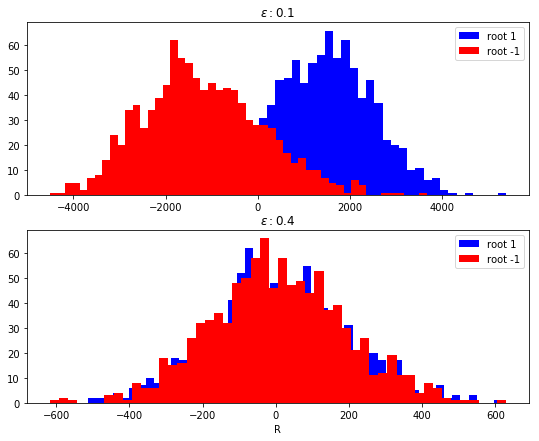

In [ ]:
def getRvals(Nruns,
             b,
             eps,
             depth,
             root):
    RL = []
    for k in range(Nruns):
        spinAL = runRandFlow(depth=depth, 
                             b=b,
                             eps=eps,
                             root=root) 
        RL.append(np.sum(spinAL[-1]))
    
    return RL

Nruns = 1000
depth = 15
b = 2

plt.figure(figsize=(9,7))
for k, eps in enumerate([0.1, 0.4]):
    plt.subplot(2,1,1+k)
    plt.title('$\epsilon:$'+str(eps))
    if k == 1:
        plt.xlabel('R')
    for n, root in enumerate([1,-1]):
        RL = getRvals(Nruns, b, eps, depth, root)
        plt.hist(RL, bins=50, color=['b','r'][n], label='root '+str(root))
    plt.legend()
    plt.savefig('Rhist.pdf')

### Fixed points of ordered states in ML reconstruction

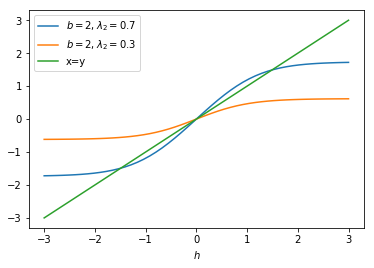

In [ ]:
b = 2
h = np.linspace(-3, 3)
plt.plot(h, b*np.arctanh(0.7*np.tanh(h)), label='$b=2, \lambda_2=0.7$')
plt.plot(h, b*np.arctanh(0.3*np.tanh(h)), label='$b=2, \lambda_2=0.3$')
plt.plot(h, h, label='x=y')
plt.xlabel('$h$')
plt.legend()
plt.savefig('fixed_points.pdf')
plt.show()

## The full generation-reconstruction recurrence

We consider $q$-state Potts channel.

Generate initial ($n=0$) distribution $Q^s_{n=0}$ for $s=0$ (distributions for other $s$ can be obtained by permutations).  

In [ ]:
def getInitQ(N, # number of samples 
             q # number of states
            ):
    Q = np.zeros((q, N)) 
    Q[0] = 1.
    return Q

Plot the distribution in the cases $q=2,3$

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plotQ(Q):
    assert Q.shape[0] ==2 or Q.shape[0] == 3    
    if Q.shape[0] ==2:
        fig = plt.figure()
        plt.axis('equal')
        plt.plot([1, 0], [0, 1], '--r', label='simplex')
        plt.plot(Q[0], Q[1], '.', label='$Q^1_n$') 
        plt.legend()
        fig = plt.figure()
        plt.title('Distribution histogram for $Q^1$')
        plt.hist(Q[0], bins=100)
    else:   
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=30., azim=30)
        ax.plot([1, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], '--r', label='simplex')
        ax.plot(Q[0], Q[1], Q[2], '.', label='$Q^1_n$')
        plt.legend()
    plt.show()

Initial distribution for $q=2$

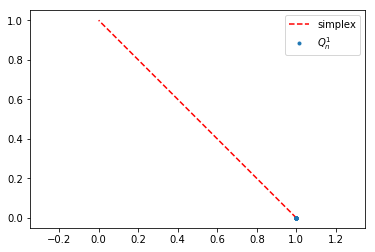

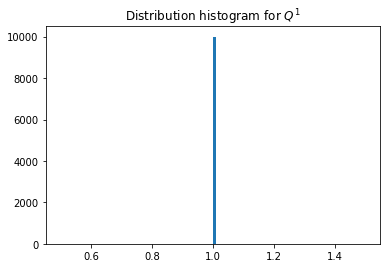

In [ ]:
N = 10000
q = 2
Q = getInitQ(N, q)
plotQ(Q)

Initial distribution for $q=3$

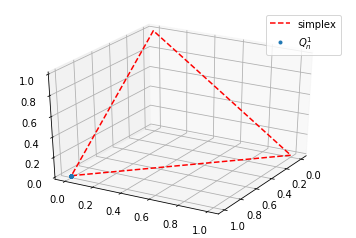

In [ ]:
N = 10000
q = 3
Q = getInitQ(N, q)
plotQ(Q)

One iteration $Q_{n+1}=\Phi(Q_n)$:

In [ ]:
def iterate(Q, 
            eps, # transition probabilities 
            b # branching number
           ):
    (q, N) = Q.shape
    Z = np.zeros((b, N), 'int')
    assert eps < 1.
    # generate random next stage states, assuming root state is 0
    for i in range(b): # loop over decendants
        z1 = np.random.rand(N) < (1.-q*eps) # do we stay in state 0?
        z2 = np.floor(q*np.random.rand(N)) # the new state if we don't
        Z[i] = ((1-z1)*z2).astype('int')
        
    # ensure points in the distributions are random
    randperm = np.zeros((b,N), 'int')
    for m in range(b):
        randperm[m] = np.random.permutation(N) 
        
    R = np.ones((q, N))   
    for q1 in range(q):
        for m in range(b):
            f = 0.
            for q2 in range(q):
                f1 = ((1.-(q-1)*eps)*(q1 == q2) + eps*(q1 != q2))
                f2 = Q[(q2-Z[m])%q, randperm[m]] 
                f += f1*f2
            R[q1] *= f 
    Qnew = R/R.sum(axis=0)
    return Qnew

Example: $q=2$, limiting $Q$ for $\epsilon$ slightly below KS critical value

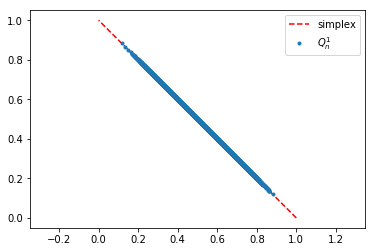

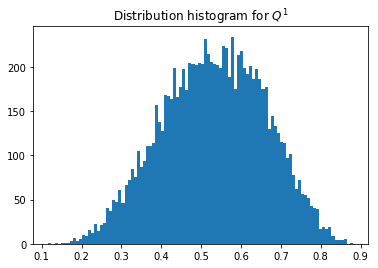

In [ ]:
q = 2
b = 2
Q = getInitQ(N, q)
eps = 0.14

for _ in range(1000):
    Q = iterate(Q, eps, b)
plotQ(Q)

The same, but for $\epsilon$ slightly above cricital value

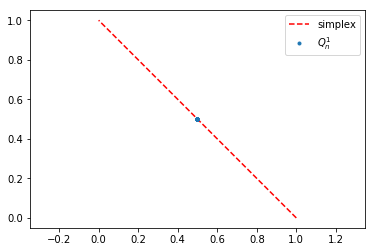

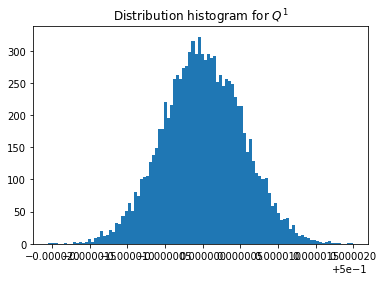

In [ ]:
q = 2
b = 2
Q = getInitQ(N, q)
eps = 0.15

for _ in range(1000):
    Q = iterate(Q, eps, b)
plotQ(Q)

Example: $q=3$, $ϵ$ slightly below KS critical value

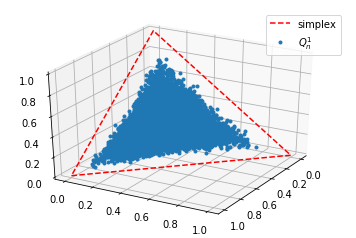

In [ ]:
q = 3
b = 4
Q = getInitQ(N, q)
eps = 1./6.1

for _ in range(1000):
    Q = iterate(Q, eps, b)
plotQ(Q)

Same, but $ϵ$ above KS critical value

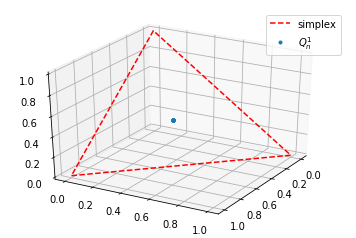

In [ ]:
q = 3
b = 4
Q = getInitQ(N, q)
eps = 1./5.9

for _ in range(1000):
    Q = iterate(Q, eps, b)
plotQ(Q)

### Potts model with a large $q$

Transition matrix:
[[8.004e-01 2.000e-04 2.000e-04 ... 2.000e-04 2.000e-04 2.000e-04]
 [2.000e-04 8.004e-01 2.000e-04 ... 2.000e-04 2.000e-04 2.000e-04]
 [2.000e-04 2.000e-04 8.004e-01 ... 2.000e-04 2.000e-04 2.000e-04]
 ...
 [2.000e-04 2.000e-04 2.000e-04 ... 8.004e-01 2.000e-04 2.000e-04]
 [2.000e-04 2.000e-04 2.000e-04 ... 2.000e-04 8.004e-01 2.000e-04]
 [2.000e-04 2.000e-04 2.000e-04 ... 2.000e-04 2.000e-04 8.004e-01]]
Appearing states: [0, 289, 320, 624, 687, 241, 240, 598, 401, 997, 830, 271, 584, 259, 143, 802, 592, 838]


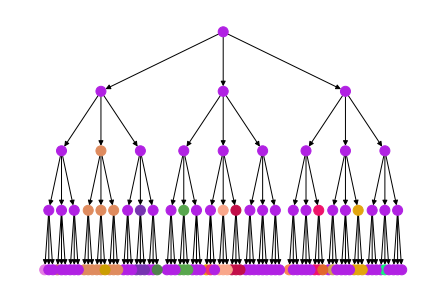

In [ ]:
from matplotlib.pyplot import cm

def getPotts(q, eps):
    M = (1.-(q-1)*eps)*np.eye(q)+eps*np.ones((q,q))
    return M


def makeRandTransitions(spinA,  # input spins at a certain hierarchy level, as an array of values 0,1,2,..,S-1
                        M,      # S x S matrix of transition probabilities p(\sigma_1|\sigma_0)
                        b,      # branching number
                        ):
    shape1 = [b] + list(spinA.shape)
    spinA1 = np.zeros(shape1, 'int')
    S = M.shape[0]
    cumP = M.cumsum(axis=0)
    for a in range(b):
        P = np.random.rand(*list(spinA.shape))        
        for s in range(S):
            spinA1[a] += P > cumP[s, spinA]
    
    assert np.all(spinA1 >= 0) and np.all(spinA1 < S)
        
    return spinA1    # spins at the next level


def runRandFlow(depth, 
                M,
                b,
                root=1
               ): # run a full random hierarchical flow of spin flips
    spinA = np.array([root], 'int')
    spinAL = [spinA]

    for level in range(depth):
        spinAL.append(makeRandTransitions(spinAL[-1], M, b))
    return spinAL # the full flow as a list of arrays


def spinAL2tree(spinAL,
                plot=True,
                savefig=False
               ): # convert spin array list into a tree
    tree = nx.DiGraph()
    for level in range(len(spinAL)):
        for index, value in np.ndenumerate(spinAL[level]):
            node = tree.add_node(index)
            tree.nodes[index]['v'] = value
            if level > 0:
                predecessor = tuple(list(index)[1:])
                tree.add_edge(predecessor, index)
    
    # assign reasonable positions and colors for visualization
    pos = nx.spring_layout(tree)
    for level in range(len(spinAL)):  
        for index, value in np.ndenumerate(spinAL[level]):
            pos[index] = (np.sum([3.1**(l-level)*(index[l]-(spinAL[level].shape[l]-1.)/2)/(spinAL[level].shape[l]-1.+1e-8) 
                                  for l in range(level+1)]),
                         -level)  
    
    states = list(dict.fromkeys([tree.nodes[node]['v'] for node in tree.nodes]))
    print ('Appearing states:', states)
    
    colorL = [np.random.rand(3,) for _ in range(1+np.max([np.max(spinA) for spinA in spinAL]))]
    if plot:
        nx.draw(tree, pos, node_color=[colorL[tree.nodes[node]['v']] for node in tree.nodes], node_size=100)
        if savefig:
            plt.savefig('tree.pdf')
    return tree

M = getPotts(q=1000, eps=0.0002)
print ('Transition matrix:')
print (M)

spinAL = runRandFlow(depth=4, 
                     M=M,
                     b=3,
                     root=0)

tree = spinAL2tree(spinAL, savefig=True)